# Алгоритмы кластеризации

Задание на сегодня состоит из двух задач. Нужно реализовать алгоритмы k-means и иерархическую кластеризацию.

### 1. K-Means (1 балл)

Реализуйте метод сжатия изображений в формате PNG с помощью кластеризации пикселей.

Общая схема работы метода:

* С помощью алгоритма Ллойда построить по изображению набор из **K** базовых цветов. Базовый цвет – это центроид в пространстве RGB.

* Преобразовать исходное изображение в новое, в котором каждый пиксель заменен на ближайший к нему базовый цвет.

Необходимо, чтобы преобразованное изображение визуально не сильно отличалось от исходного

Расстояние между точками евклидово

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### Загрузка данных

In [ ]:
!wget https://github.com/ivartb/clusterization/blob/master/flower.png

--2024-05-02 23:23:08--  https://github.com/ivartb/clusterization/blob/master/flower.png
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘flower.png’

flower.png              [ <=>                ] 143.33K  --.-KB/s    in 0.008s  

2024-05-02 23:23:09 (18.6 MB/s) - ‘flower.png’ saved [146771]



In [2]:
# Загрузим картинку
img = plt.imread("flower.png")[:,:,:3]

# Теперь в переменной img находится трехмерный массив чисел.
print(img.shape)

(427, 640, 3)


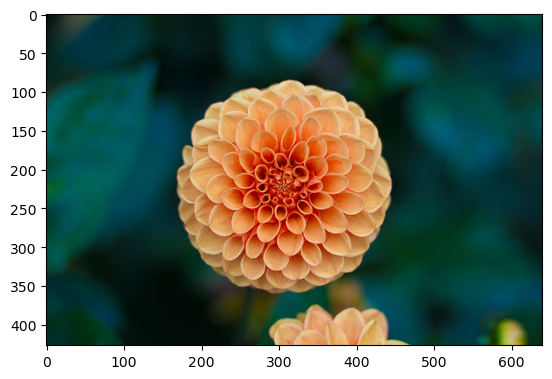

In [ ]:
plt.imshow(img)

In [ ]:
# Цвет каждой точки задается трехмерным вектором в пространстве RGB. Это наши признаки.
print(img[400, 500])

[0.04313726 0.12156863 0.11372549]


In [ ]:
# Преобразуем массив в двумерный. Теперь первая координата – номер точки, вторая – ее признаки
X = img.reshape((-1,3))
print(X.shape)

(273280, 3)


#### Кластеризация

Примерная структура класса. Можно менять, если хотите (уже не примерная -> реализация)

In [ ]:
from scipy.spatial.distance import cdist

# считаем расстояния -> dist_matrix
# определяем какой точке какой кластер -> X_labels
# расчитываем центр масс для каждого кластера -> new_centroids
# считаем лосс -> iter_loss
# если new_centroids и self.centroids несильно различны, то заканчиваем
# если iter_loss < min_loss -> замена self.centroids
# повторить
def distances(X, centroids):
    '''
    Returns distance from each sample to all centroids
    :param X: array-like of shape (n_samples, n_features)
        Training instances to cluster
    :return dist: array-like of shape (n_samples, n_clusters)
        Matrix of distances
    '''
    dist = cdist(X, centroids, 'euclidean')
    return dist

def loss(dist):
    '''
    :param dist: array-like of shape (n_samples, n_clusters)
        Matrix of distances
    :return loss: float
        Value of the loss function
    '''
    loss = np.sum((dist**2).min(axis=1))/dist.shape[0]
    return loss

class KMeans(object):
    def __init__(self, n_clusters, max_iter, seed=0, tol=0.001):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.centroids = None
        self.losses = []
        self.seed = seed
        self.tol = tol

        self.dist_matrix = np.zeros((1, self.n_clusters))

    def initialize(self, X):
        '''
        Initialize centroids
        :param X: array-like of shape (n_samples, n_features)
            Training instances to cluster

        '''
        self.centroids = X[np.random.choice(len(X), self.n_clusters, replace=False)]
        self.dist_matrix = distances(X, self.centroids)
        self.losses.append(loss(self.dist_matrix))

    def fit_predict(self, X):
        '''
        Implements Lloyd's algorithm
        :param X: array-like of shape (n_samples, n_features)
            Training instances to cluster
        :return labels : ndarray of shape (n_samples,)
            Index of the cluster each sample belongs to.
        '''
        np.random.seed(self.seed)
        self.initialize(X)

        for i in range(self.max_iter):
            new_centroids = np.zeros((self.n_clusters, X.shape[1]))
            X_labels = np.argmin(self.dist_matrix, axis=1)

            for i in range(self.n_clusters):
                center = np.average(X[np.where(X_labels == i)], axis=0)
                new_centroids[i] = center.copy()

            if np.allclose(self.centroids, new_centroids, atol=self.tol):
                return self.centroids

            new_matrix = distances(X, new_centroids)
            iter_loss = loss(new_matrix)

            if iter_loss < self.losses[-1]:
                self.dist_matrix = new_matrix
                self.losses.append(iter_loss)
                self.centroids = new_centroids

        return self.centroids

Запустим кластеризацию на наших данных

In [ ]:
cls = KMeans(n_clusters=8, max_iter=100, seed=0)
y_pred = cls.fit_predict(X)
losses = cls.losses
centroids = cls.centroids

Посмотрим, как убывала функция ошибки

Text(0, 0.5, 'Loss')

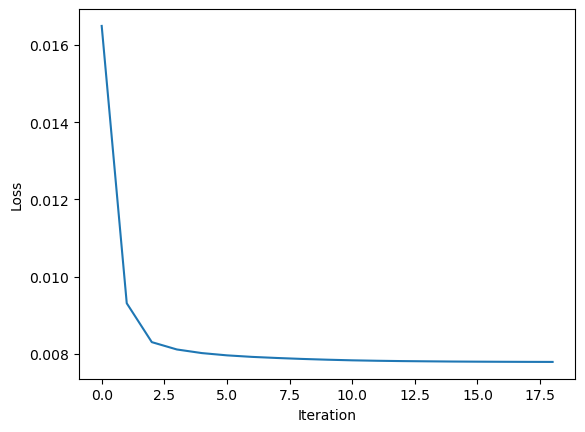

In [ ]:
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')

Наши центроиды – цвета в пространстве RGB. Можно их нарисовать

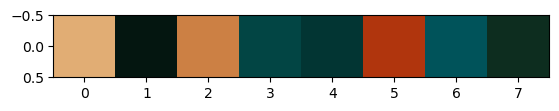

In [ ]:
plt.imshow([centroids])

Теперь сделайте из `X` матрицу `Y`, в которой координаты каждой точки заменены на координаты центроида

In [ ]:
Y = centroids[np.argmin(cdist(X, centroids, 'euclidean'), axis=1)]

Посмотрим, что получилось

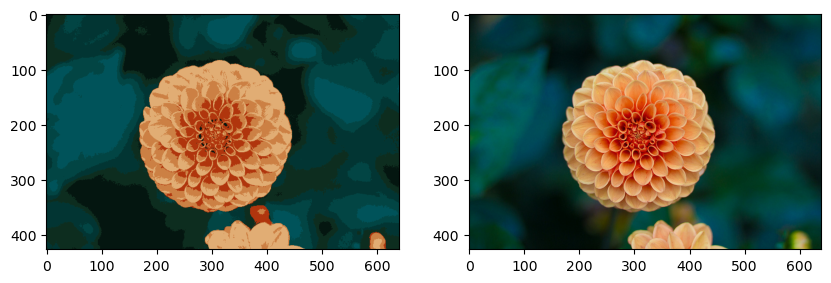

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.imshow(np.array(Y).reshape(img.shape))
ax2.imshow(img)
plt.show()

Поэкспериментируйте с разным числом кластеров

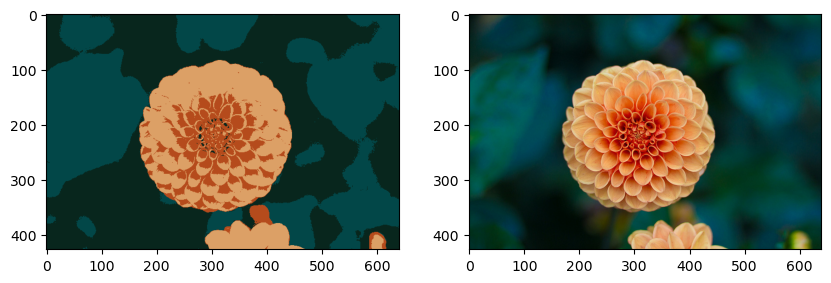

In [ ]:
cls = KMeans(n_clusters=4, max_iter=100, seed=0)
y_pred = cls.fit_predict(X)
losses = cls.losses
centroids = cls.centroids

Y = centroids[np.argmin(cdist(X, centroids, 'euclidean'), axis=1)]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
_ = ax1.imshow(np.array(Y).reshape(img.shape))
_ = ax2.imshow(img)

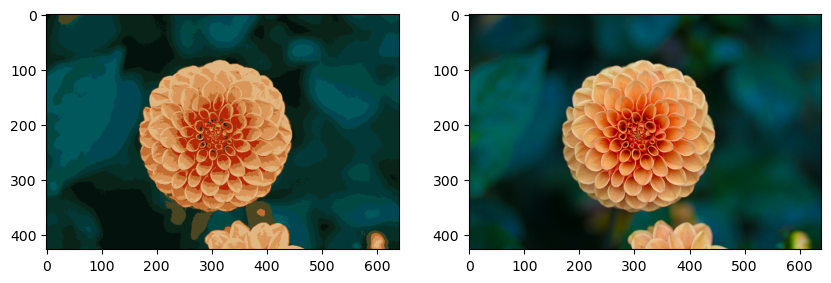

In [ ]:
cls = KMeans(n_clusters=12, max_iter=100, seed=0)
y_pred = cls.fit_predict(X)
losses = cls.losses
centroids = cls.centroids

Y = centroids[np.argmin(cdist(X, centroids, 'euclidean'), axis=1)]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
_ = ax1.imshow(np.array(Y).reshape(img.shape))
_ = ax2.imshow(img)

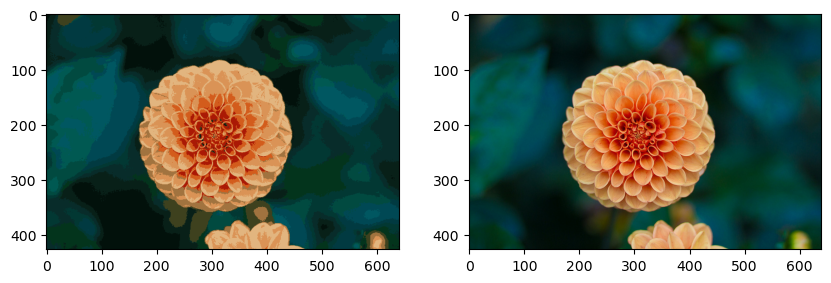

In [ ]:
cls = KMeans(n_clusters=16, max_iter=100, seed=0)
y_pred = cls.fit_predict(X)
losses = cls.losses
centroids = cls.centroids

Y = centroids[np.argmin(cdist(X, centroids, 'euclidean'), axis=1)]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
_ = ax1.imshow(np.array(Y).reshape(img.shape))
_ = ax2.imshow(img)

### 2. Иерархическая кластеризация (1 балл)

Реализуйте алгоритм иерархической кластеризации \
Для вычисления расстояний между кластерами используйте среднее расстояние между входящими в них точками.

#### 2.1. Реализуйте функцию `distance_matrix`, вычисляющую матрицу попарных расстояний между точками.
В качестве метрики мы будем использовать евклидово расстояние

In [ ]:
def distance_matrix(X):
    '''
    Compute matrix of pair-wise distances between samples
    :param X: array-like of shape (n_samples, n_features)
        Samples
    :return D: array-like of shape (n_samples, n_samples)
        Matrix of pair-wise distances between samples
    '''
    D = cdist(X, X, 'euclidean')

    return D

#### 2.2. Реализуйте функцию `linkage`.

На вход подается матрица расстояний. На выходе – результат кластеризации в виде матрицы связей. Строки этой матрицы соответствуют операции объединения кластеров. Каждая строка имеет вид

```[C1, C2, dist(C1, C2), N]```

где `C1` и `C2` – номера объединяемых кластеров, `dist(C1, C2)` – расстояние между объединяемыми кластерами, `N` – число точек в новом кластере

In [ ]:
# cluster labels for each point = [1, 2, 3, ...] len() = n (D: n*n)
# cluster labels for matrix [1, 2, ... 11, 12... n + m] len() = n - m шаг
# Уже реализованная linkage
def linkage(D):
    '''
    :param D: array-like of shape (n_samples, n_samples)
            Matrix of pair-wise distances between samples
    :return linkage: Linkage matrix
    '''
    D1 = D.copy()
    n = D.shape[0]
    linkage = []
    clusters_points = np.arange(n)
    clusters_matrix = np.arange(n)

    for i in range(n - 1):
        # кластеры для мерджа
        x, y = np.where(D1 == np.min(D1[np.nonzero(D1)]))[0]
        new_cluster = clusters_matrix[-1] + 1
        N = len(np.where((clusters_points == clusters_matrix[x]) | (clusters_points == clusters_matrix[y]))[0])
        linkage.append([clusters_matrix[x], clusters_matrix[y], D1[x, y], N])

        # индексы из начального массива для кластера x и y
        x_points = np.where(clusters_points == clusters_matrix[x])[0]
        y_points = np.where(clusters_points == clusters_matrix[y])[0]

        # проход по остальным кластерам
        new_col = []
        for cluster in clusters_matrix:
            # игнорируем пересечения x и y и самих с собой
            if cluster == clusters_matrix[x] or cluster == clusters_matrix[y]:
                continue

            # теперь есть индексы кластера, для которого считаем расстояния
            C = np.where(clusters_points == cluster)[0]

            # не придумал ничего умнее, чем сложить всевозможные пары
            dist = 0
            for i in C:
                for j in x_points:
                    dist += D[i, j]
                for j in y_points:
                    dist += D[i, j]
            dist /= len(C)*(len(x_points) + len(y_points))

            # добавим расстояние в новую колонку
            new_col.append(dist)
        new_col.append(0)
        new_col = np.array(new_col)

        # теперь переобределяем 2 массива индексов и матрицу расстояний
        # индексы всех точек
        clusters_points[x_points] = new_cluster
        clusters_points[y_points] = new_cluster

        # индексы в D1 матрице кластеров
        clusters_matrix = np.delete(clusters_matrix, [x, y])
        clusters_matrix = np.concatenate((clusters_matrix, [new_cluster]))

        # Удаление столбцов и строк D1 и добавление в конце новых
        D1 = np.delete(D1, [x, y], axis=0)
        D1 = np.delete(D1, [x, y], axis=1)
        D1 = np.concatenate((D1, [new_col[:-1]]), axis=0)
        D1 = np.concatenate((D1, new_col[:, np.newaxis]), axis=1)

    return linkage

####  Проверка 1

In [ ]:
# Нам дана матрица расстояний
D = np.array([[0.  , 0.74, 0.85, 0.54, 0.83, 0.92, 0.89],
              [0.74, 0.  , 1.59, 1.35, 1.2 , 1.48, 1.55],
              [0.85, 1.59, 0.  , 0.63, 1.13, 0.69, 0.73],
              [0.54, 1.35, 0.63, 0.  , 0.66, 0.43, 0.88],
              [0.83, 1.2 , 1.13, 0.66, 0.  , 0.72, 0.55],
              [0.92, 1.48, 0.69, 0.43, 0.72, 0.  , 0.8 ],
              [0.89, 1.55, 0.73, 0.88, 0.55, 0.8 , 0.  ]])

# кластеризуем
Z = linkage(D)

# и напечатаем что получилось
print(np.array(Z))

[[ 3.    5.    0.43  2.  ]
 [ 4.    6.    0.55  2.  ]
 [ 2.    7.    0.66  3.  ]
 [ 0.    1.    0.74  2.  ]
 [ 8.    9.    0.82  5.  ]
 [10.   11.    1.12  7.  ]]


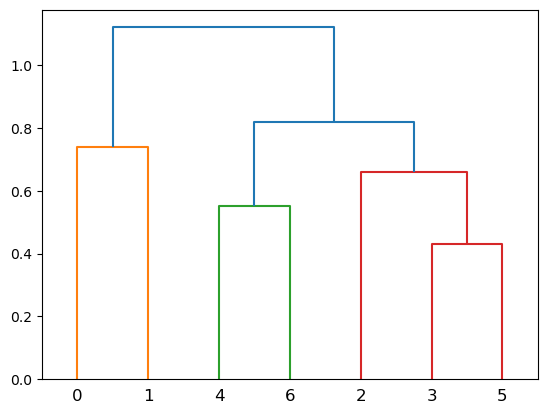

In [ ]:
# для построения дендрограммы воспользуемся функцией из библиотеки scipy
from scipy.cluster.hierarchy import dendrogram

# должна получиться картинка из начала этого раздела
_ = dendrogram(Z) # он совпал, но картинка с примером не подгрузилась

####  Проверка 2

In [ ]:
D = np.array([
    [0.  , 0.43, 0.93, 0.85, 0.94, 0.7 , 0.95, 0.79, 0.89, 1.34, 0.8 , 0.64, 1.42, 1.37, 0.86, 1.2 , 0.49, 0.19, 1.48, 0.86],
    [0.43, 0.  , 0.66, 0.7 , 1.48, 0.58, 0.7 , 0.55, 0.68, 1.45, 1.31, 0.37, 1.24, 1.69, 0.91, 1.28, 1.04, 0.29, 0.94, 1.05],
    [0.93, 0.66, 0.  , 1.01, 1.42, 0.8 , 0.76, 1.18, 0.21, 1.18, 1.35, 0.82, 0.68, 0.85, 0.75, 1.01, 0.93, 1.03, 0.6 , 0.91],
    [0.85, 0.7 , 1.01, 0.  , 1.02, 0.22, 0.89, 0.91, 0.79, 1.47, 1.04, 1.51, 0.71, 1.63, 0.34, 1.05, 1.24, 0.56, 1.09, 1.25],
    [0.94, 1.48, 1.42, 1.02, 0.  , 1.46, 1.48, 0.95, 1.44, 1.08, 0.3 , 1.29, 1.28, 0.65, 1.  , 0.8 , 0.8 , 0.92, 1.48, 0.65],
    [0.7 , 0.58, 0.8 , 0.22, 1.46, 0.  , 0.77, 1.  , 0.65, 1.25, 1.27, 1.36, 0.81, 1.56, 0.37, 0.98, 1.17, 0.68, 0.88, 1.23],
    [0.95, 0.7 , 0.76, 0.89, 1.48, 0.77, 0.  , 1.41, 1.08, 1.61, 1.65, 0.89, 0.76, 1.32, 0.64, 0.7 , 0.59, 1.07, 0.49, 0.91],
    [0.79, 0.55, 1.18, 0.91, 0.95, 1.  , 1.41, 0.  , 1.05, 0.73, 1.08, 0.7 , 1.49, 1.17, 1.  , 1.34, 1.45, 0.49, 1.06, 1.3 ],
    [0.89, 0.68, 0.21, 0.79, 1.44, 0.65, 1.08, 1.05, 0.  , 0.96, 1.09, 0.94, 0.44, 1.06, 0.9 , 1.47, 1.2 , 0.79, 1.04, 1.39],
    [1.34, 1.45, 1.18, 1.47, 1.08, 1.25, 1.61, 0.73, 0.96, 0.  , 0.96, 1.1 , 1.05, 0.48, 1.36, 1.26, 1.38, 1.38, 1.03, 1.38],
    [0.8 , 1.31, 1.35, 1.04, 0.3 , 1.27, 1.65, 1.08, 1.09, 0.96, 0.  , 1.08, 1.09, 0.79, 1.4 , 1.03, 1.02, 0.78, 1.79, 0.86],
    [0.64, 0.37, 0.82, 1.51, 1.29, 1.36, 0.89, 0.7 , 0.94, 1.1 , 1.08, 0.  , 1.42, 1.2 , 1.61, 1.3 , 0.86, 0.68, 1.04, 0.83],
    [1.42, 1.24, 0.68, 0.71, 1.28, 0.81, 0.76, 1.49, 0.44, 1.05, 1.09, 1.42, 0.  , 0.99, 0.84, 1.2 , 1.21, 1.22, 0.97, 1.58],
    [1.37, 1.69, 0.85, 1.63, 0.65, 1.56, 1.32, 1.17, 1.06, 0.48, 0.79, 1.2 , 0.99, 0.  , 1.13, 0.61, 1.  , 1.6 , 0.81, 0.83],
    [0.86, 0.91, 0.75, 0.34, 1.  , 0.37, 0.64, 1.  , 0.9 , 1.36, 1.4 , 1.61, 0.84, 1.13, 0.  , 0.68, 0.89, 0.86, 0.65, 1.04],
    [1.2 , 1.28, 1.01, 1.05, 0.8 , 0.98, 0.7 , 1.34, 1.47, 1.26, 1.03, 1.3 , 1.2 , 0.61, 0.68, 0.  , 0.92, 1.47, 0.47, 0.42],
    [0.49, 1.04, 0.93, 1.24, 0.8 , 1.17, 0.59, 1.45, 1.2 , 1.38, 1.02, 0.86, 1.21, 1.  , 0.89, 0.92, 0.  , 0.9 , 1.18, 0.49],
    [0.19, 0.29, 1.03, 0.56, 0.92, 0.68, 1.07, 0.49, 0.79, 1.38, 0.78, 0.68, 1.22, 1.6 , 0.86, 1.47, 0.9 , 0.  , 1.56, 1.21],
    [1.48, 0.94, 0.6 , 1.09, 1.48, 0.88, 0.49, 1.06, 1.04, 1.03, 1.79, 1.04, 0.97, 0.81, 0.65, 0.47, 1.18, 1.56, 0.  , 0.84],
    [0.86, 1.05, 0.91, 1.25, 0.65, 1.23, 0.91, 1.3 , 1.39, 1.38, 0.86, 0.83, 1.58, 0.83, 1.04, 0.42, 0.49, 1.21, 0.84, 0.  ]])

Выведите Linkage матрицу и постройте дендрограмму

[[ 0.         17.          0.19        2.        ]
 [ 2.          8.          0.21        2.        ]
 [ 3.          5.          0.22        2.        ]
 [ 4.         10.          0.3         2.        ]
 [14.         22.          0.355       3.        ]
 [ 1.         20.          0.36        3.        ]
 [15.         19.          0.42        2.        ]
 [ 9.         13.          0.48        2.        ]
 [ 6.         18.          0.49        2.        ]
 [12.         21.          0.56        3.        ]
 [11.         25.          0.56333333  4.        ]
 [ 7.         30.          0.6325      5.        ]
 [16.         26.          0.705       3.        ]
 [28.         32.          0.78166667  5.        ]
 [24.         29.          0.80666667  6.        ]
 [23.         27.          0.87        4.        ]
 [31.         34.          0.995      11.        ]
 [33.         36.          1.05890909 16.        ]
 [35.         37.          1.184375   20.        ]]


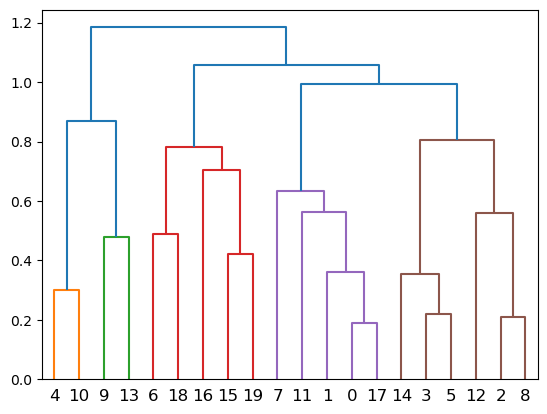

In [ ]:
Z = linkage(D)
print(np.array(Z))
_ = dendrogram(Z)

#### 2.3. Digits dataset

In [ ]:
from sklearn import datasets

# загрузим датасет Digits. Он состоит из рукописных изображений цифр
digits = datasets.load_digits().images

In [ ]:
# выберем 20 случайных изображений
digits = np.random.permutation(digits)[:20]

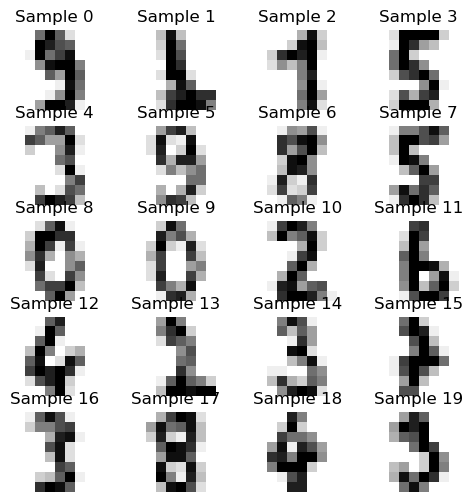

In [ ]:
# вот они
_, axes = plt.subplots(nrows=5, ncols=4, figsize=(6, 6))
for i, (ax, image) in enumerate(zip(axes.flatten(), digits)):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f'Sample {i}')

In [ ]:
# каждое изображение – матрица размера (8, 8). Давайте вытянем ее в вектор признаков
XX = digits.reshape((digits.shape[0], -1))

**Кластеризуйте вектора и постройте дендрограмму. Какие выводы можно из нее сделать?**

[[ 8.          9.         22.02271555  2.        ]
 [ 3.          7.         25.45584412  2.        ]
 [ 6.         17.         27.5680975   2.        ]
 [14.         16.         30.38091506  2.        ]
 [ 0.          5.         30.91924967  2.        ]
 [12.         18.         34.0147027   2.        ]
 [ 4.         23.         35.57844557  3.        ]
 [ 1.         13.         35.70714214  2.        ]
 [24.         26.         37.81393181  5.        ]
 [22.         28.         41.41789759  7.        ]
 [10.         29.         42.95837631  8.        ]
 [19.         20.         43.15575774  3.        ]
 [11.         27.         44.09849714  3.        ]
 [30.         31.         44.98140073 11.        ]
 [15.         25.         46.14880763  3.        ]
 [21.         33.         46.96912915 13.        ]
 [ 2.         35.         50.01984458 14.        ]
 [32.         36.         51.97554296 17.        ]
 [34.         37.         54.46661835 20.        ]]


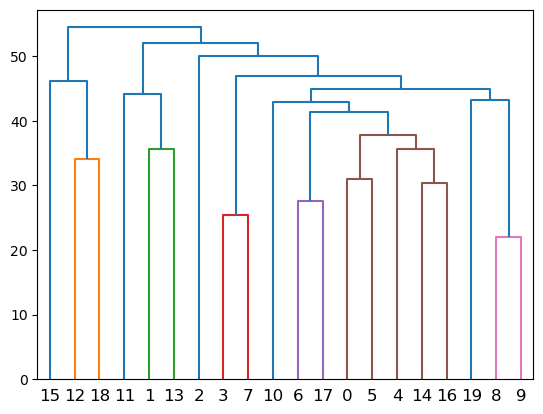

In [ ]:
D = distance_matrix(XX)
Z = linkage(D)
print(np.array(Z))
_ = dendrogram(Z)

[[13.         15.         19.97498436  2.        ]
 [ 3.          4.         21.88606863  2.        ]
 [14.         20.         22.53021117  3.        ]
 [ 2.         10.         24.49489743  2.        ]
 [12.         21.         29.72372666  3.        ]
 [ 8.         19.         35.44009029  2.        ]
 [22.         24.         36.02403616  6.        ]
 [ 1.         11.         38.57460304  2.        ]
 [ 0.         23.         38.73449793  3.        ]
 [ 9.         18.         38.83297568  2.        ]
 [ 7.         17.         39.11521443  2.        ]
 [ 6.         16.         40.32369031  2.        ]
 [25.         27.         41.29944172  4.        ]
 [ 5.         31.         44.59701266  3.        ]
 [28.         32.         45.11057415  7.        ]
 [29.         34.         48.40886525  9.        ]
 [26.         35.         49.8876298  15.        ]
 [33.         36.         50.96568436 18.        ]
 [30.         37.         51.79571465 20.        ]]


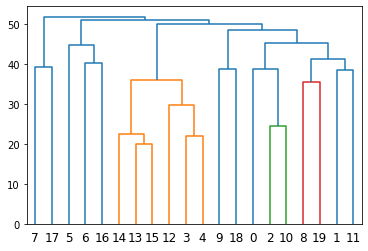

In [ ]:
# Что должно было получиться

**Выводы:**


1) При сжатии картинки можно видеть, что качество изображения уменьшается с уменьшением кол-ва кластеров, что согласуется с ожиданиями. При этом достаточно 8-10 кластеров, для достаточно хорошего качества. \
2) При иерархической кластеризации, все, кроме последнего задания совпали с вашими. В последнем примере, я конечно не все проверил, но все кластеры объединились в нужном порядке. Например, у меня 12 и 18 сэмплы сразу объединяются, что логично, тк это 4-ки. У вас же 12 и 3 с 4 объединяются раньше, хотя там 4-ка и 5-ка с 3-й. Может быть я в чем-то ошибся, но кажется, все порядок кластеров совпадает с похожестью картинок. Буду искать ошибки...